# SIIM-ISIC - Train

##### In this notebook we focus on:
 1. Reading in the data
 - Data manipulation and preparation
 - Image augmentation
 - Model architecture creation
 - Cross Validation strategy creation
 - Model training
 - Test-time augmentations (TTAs)
 - Submission creation

##### Ideas I wasn't able to explore:
- External data
- Focal loss
- TFRecords
- Having different img size inputs within CV strategy (e.g. fold 0 = 128x128, fold 1 = 256x256)
- Pixel normalisation / centering. For some reason this was computationally too expensive, so maybe I didn't do it properly...

##### Things I learned:
 - Setting up the entire pipeline simply from the start. All the way from data reading to submission - a baseline procedure in place at the beginning makes it so much easier to plug and play.
 - It is so important to track and record all your experiments! And in as much detail as possible!!
 - Having a development environment style notebook, where if you want to change parameters it is very easy to do and the code doesn't break.
 - Test time augmentations are critical in both OOF training validation AND test predictions. Under the impression so far that any TTAs you do in generating submission predictions should be the same as in making OOF predictions (although would appreciate being corrected if this is not the case).
 - Looping through images and individually doing augmentations are more time effective than doing augmentations to an entire batch.
 - Learning rate schedules are so important - they need to fit in with your own specific model patterns and nuances. There is no one-size-fits all schedule.
 - Definitely consider model checkpoints, and early stopping continues to be effective (particularly on a second validation set).
 - Doing slightly different things in each fold (changing augs slightly, for example) can be effective.
 - Starting training iterations on small image sizes (128x128) while you work out baseline architecture, before increasing to larger images with a more established architecture can save a lot of time. But be careful about memory capability!
 - If possible, train the same model arhitectures under different seeds and compare CV differences as a way to avoid overfitting. These can even be ensembled at the end.
 - Batch normalisation and image normalistion are completely different, and some people don't realise this!
 - The secret to success, is a robust and effective CV strategy.  

## 1.00 Load Packages

In [2]:
# General packages
import pandas as pd
import numpy as np
import re 
import os
import gc
import json
import math
import random
from tqdm import tqdm, tqdm_notebook
#tqdm_notebook().pandas()
import datetime
import time
import warnings
warnings.filterwarnings('ignore')
from collections import Counter, defaultdict

# Data vis packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data prep
import pydicom as dicom # to handle dicom files
import cv2
import imgaug.augmenters as iaa
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Modelling packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as k
from tensorflow.keras.layers import Input, Add, Dense, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from sklearn.model_selection import GroupKFold

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

strategy = tf.distribute.get_strategy()
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

# Data access
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)

Num GPUs Available:  1
REPLICAS: 1


## 2.00 Read Data

In [4]:
# Define paths - mel stands for melanoma
input_path = '../input'
mel_dir_path = os.path.join(input_path, 'siim-isic-melanoma-classification')

train_metadata_path = os.path.join(mel_dir_path, 'train.csv')
test_metadata_path = os.path.join(mel_dir_path, 'test.csv')
sample_sub_path = os.path.join(mel_dir_path, 'sample_submission.csv')

train_img_path = os.path.join(mel_dir_path, 'train')
test_img_path = '512x512_jpgs/test'

# Read train metadata
train_metadata = pd.read_csv(train_metadata_path)

# Read sample submission
sample_sub = pd.read_csv(sample_sub_path)

preprocessed_images_path = 'preprocessed_images/'

# Remove duplicates
duplicates = pd.read_csv('2020_Challenge_duplicates.csv')

train_metadata = train_metadata[(~train_metadata['image_name'].isin(duplicates['ISIC_id_paired']))]

In [5]:
# Some definitions going forward
ROWS = 512 # Default row size
COLS = 512 # Default col size
CHANNELS = 3

EPOCHS = 8
BATCH_SIZE = 4
CLASSES = 2

# Read all images in and subset in CV? Or Read images inside each fold in CV?
read_images_in_fold = True

# Uncomment as appropriate

#MODEL_TO_USE = 'densenet201'
#MODEL_TO_USE = 'inception_resnetv2' 
#MODEL_TO_USE = 'xception'

#MODEL_TO_USE = 'inceptionv3'
#MODEL_TO_USE = 'vgg19'

MODEL_TO_USE = 'efficientnet_b5'
####MODEL_TO_USE = 'resnext101'
#MODEL_TO_USE = 'resnet152v2'
####MODEL_TO_USE = 'efficientnet_b0'
####MODEL_TO_USE = 'efficientnet_b1'
####MODEL_TO_USE = 'efficientnet_b2'
####MODEL_TO_USE = 'efficientnet_b3'
####MODEL_TO_USE = 'efficientnet_b4'
####MODEL_TO_USE = 'densenet169'
####MODEL_TO_USE = 'densenet121'
####MODEL_TO_USE = 'resnet50v2'
####MODEL_TO_USE = 'resnet101v2'
####MODEL_TO_USE = 'resnext50'


# Parameters for each fold
# standard_models = [128, 256, 384, 512]
# efficient_nets = [224, 240, 260, 300, 380, 456]

kfold_params = {
    0: {'ROWS':ROWS,'COLS':COLS,'AUG':'fliplr'},
    1: {'ROWS':ROWS,'COLS':COLS,'AUG':'rot90' },
    2: {'ROWS':ROWS,'COLS':COLS,'AUG':'rot180'},
    3: {'ROWS':ROWS,'COLS':COLS,'AUG':'rot270'},
    4: {'ROWS':ROWS,'COLS':COLS,'AUG':'fliplr'},
    5: {'ROWS':ROWS,'COLS':COLS,'AUG':'rot90' },
    6: {'ROWS':ROWS,'COLS':COLS,'AUG':'rot180'},
    7: {'ROWS':ROWS,'COLS':COLS,'AUG':'rot270'}

}

KFOLDS = len(kfold_params)

SEED = 14
np.random.seed(SEED)

model_name_save = MODEL_TO_USE + '_' + str(ROWS) + 'x' + str(COLS) + '_seed' + str(SEED)

# Create weights path if does not exist already
if not os.path.exists(f'weights/{model_name_save}'):
    os.mkdir(f'weights/{model_name_save}')

print(f'Model name: {model_name_save}')

Model name: efficientnet_b5_512x512_seed14


In [6]:
y_train = train_metadata['target']

def read_jpgs(filenames, rows, cols, loading_bar=True):

    # Read images in
    image_list = []
    if loading_bar == True:
        for image_name in tqdm(filenames):
            image_path = os.path.join(preprocessed_images_path, image_name) + '.jpg'
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            image = cv2.resize(image,(rows,cols))
            image_list.append(image)
    elif loading_bar == False:
        for image_name in filenames:
            image_path = os.path.join(preprocessed_images_path, image_name) + '.jpg'
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            image = cv2.resize(image,(rows,cols))
            image_list.append(image)

    return(image_list)
            
            
def prepare_images(use_raw_images=False):
    if use_raw_images == True:
        for del_filename in os.listdir(preprocessed_images_path):
            del_file_path = os.path.join(preprocessed_images_path, del_filename)
            try:
                if os.path.isfile(del_file_path) or os.path.islink(del_file_path):
                    os.unlink(del_file_path)
                elif os.path.isdir(del_file_path):
                    shutil.rmtree(del_file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (del_file_path, e))
        # Read images in
        image_list = []
        filenames = train_metadata['image_name']

        for image_name in tqdm(filenames):
            image_path = os.path.join(train_img_path, image_name) + '.dcm'
            # Read the dcm image in
            image = dicom.dcmread(image_path).pixel_array

            res = cv2.resize(image,(ROWS,COLS))
            image_list.append(res)
            # Save processed image
            new_filename = preprocessed_images_path + image_name + '.jpg'
            cv2.imwrite(new_filename, res)

    elif use_raw_images == False:
        image_list = read_jpgs(filenames=train_metadata['image_name'])
    return image_list

if read_images_in_fold == False:
    X_train_img = np.array(prepare_images())
    print(f'X_train_img shape: {X_train_img.shape}')

y_train = np.array(y_train)

## 3.00 Data Preprocessing
 
### 3.01 Train Metadata

In [7]:
# Remove diagnosis as too many 'unknown' values
# Remove benign_malignant as the same as target variable
train_df = train_metadata.drop(['diagnosis','benign_malignant'], axis=1)

# Replace whitespace in anatom_site_general_challenge with underscore
train_df['anatom_site_general_challenge'] = train_df[
    'anatom_site_general_challenge'].replace(' ', '_', regex=True)

# Encode sex feature
train_df = train_df.merge(pd.get_dummies(train_df[
    ['sex','anatom_site_general_challenge']]), left_index=True, right_index=True)

train_df['age_approx'] = train_df['age_approx'].fillna(0)

train_df.drop(['sex', 'anatom_site_general_challenge'], axis=1, inplace=True)

train_df.head()

,image_name,patient_id,age_approx,target,sex_female,sex_male,anatom_site_general_challenge_head/neck,anatom_site_general_challenge_lower_extremity,anatom_site_general_challenge_oral/genital,anatom_site_general_challenge_palms/soles,anatom_site_general_challenge_torso,anatom_site_general_challenge_upper_extremity
0,ISIC_2637011,IP_7279968,45.0,0,0,1,1,0,0,0,0,0
1,ISIC_0015719,IP_3075186,45.0,0,1,0,0,0,0,0,0,1
2,ISIC_0052212,IP_2842074,50.0,0,1,0,0,1,0,0,0,0
3,ISIC_0068279,IP_6890425,45.0,0,1,0,1,0,0,0,0,0
4,ISIC_0074268,IP_8723313,55.0,0,1,0,0,0,0,0,0,1


In [8]:
X_train_df = np.asarray(train_df.drop(['patient_id', 'target'], axis=1))

y_train = np.asarray(train_df['target'])
groups = list(train_df['patient_id'])

del [train_metadata, train_df, duplicates]

### 3.02 Train Images
Standardise images by subtracting the per-channel mean for the training dataset and dividing by the per-channel standard deviation for the whole training dataset.

In [9]:
def preprocess_imgs(train_imgs, test_imgs):
    """
    Centers images by minusing the mean and dividing by std
    
    *train_imgs: (array) train images to read in and normalise
    *test_imgs: (array) test images to read in and normalise
    """
    
    print('Preprocessing images...\n')
    # Convert pixel values to float
    train_imgs = train_imgs.astype(float)
    test_imgs = test_imgs.astype(float)

    # Get per-channel means and stds    
    train_means = train_imgs.reshape(-1, train_imgs.shape[-1]).mean(axis=0)
    train_stds = train_imgs.reshape(-1, train_imgs.shape[-1]).std(axis=0)

    # Standardise images
    train_imgs -= train_means
    train_imgs /= train_stds
    
    test_imgs -= train_means
    test_imgs /= train_stds
        
    #print(f'Train per-channel means: {train_imgs.reshape(-1, train_imgs.shape[-1]).mean(axis=0)}')
    #print(f'Trin per-channel stds: {train_imgs.reshape(-1, train_imgs.shape[-1]).std(axis=0)}')

    return(train_imgs, test_imgs) 

## 4.00 Train Data Augmentation

In [10]:
# Create augmentation pipelines

def make_train_augmentations(X_img, X_met, y, p, aug):
    """
    Make a random subset of p proportion. Apply augmentations
    to the subset and append back to the original dataset, 
    making necessary changes to labels.
    
    *X_img: (array) Train images to read in and augment
    *X_met: (array) Train metadata to copy as per augmentated images
    *y: (array) Train labels to copy as per augmented images
    *p: (float) sample size probability
    *aug: (string) ['fliplr', 'rot90', 'rot180', 'rot270']
    """
    
    print('Augmenting images...')
    # Get a sample of X and y based on p proportion
    sample_size = int(round(len(y) * p))
    idx_sample = random.sample(range(0, len(y), 1), sample_size)

    # Make augmentations to sample
    if aug == 'fliplr':
        X_img = np.concatenate((X_img,
                                np.array([np.fliplr(X_img[i]) for i in idx_sample])),
                               axis=0)
    elif aug == 'rot90':
        X_img = np.concatenate((X_img,
                                np.array([np.rot90(X_img[i], 1) for i in idx_sample])),
                               axis=0)
    elif aug == 'rot180':
        X_img = np.concatenate((X_img,
                                np.array([np.rot90(X_img[i], 2) for i in idx_sample])),
                               axis=0)
    elif aug == 'rot270':
        X_img = np.concatenate((X_img,
                                np.array([np.rot90(X_img[i], 3) for i in idx_sample])),
                               axis=0)
    
    # Copy metadata accordingly
    X_met_sample = np.array([X_met[i] for i in idx_sample])
    X_met = np.concatenate((X_met, X_met_sample), axis=0)
    del X_met_sample
    
    # Copy labels accordingly
    y_sample = np.array([y[i] for i in idx_sample])
    y = np.concatenate((y, y_sample), axis=0)
    del y_sample

    #X_img, X_met, y = shuffle(X_img, X_met, y, random_state=SEED)

    return(X_img, X_met, y)

In [11]:
if read_images_in_fold == False:
    print(f'Train imgs shape: {X_train_img.shape}')
print(f'Train dataframe shape: {X_train_df.shape}')
print(f'Train targets shape: {y_train.shape}')

Train dataframe shape: (32701, 10)
Train targets shape: (32701,)


## 5.00 Modelling
### 5.01 Class Weighting

In [12]:
# Due to the high data imbalance, we add extra weight to the target class
neg, pos = np.bincount(y_train)

weight_for_0 = (1 / neg)*(len(y_train)) / 2.0 
weight_for_1 = (1 / pos)*(len(y_train)) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 28.14


### 5.02 Learning Scheduler

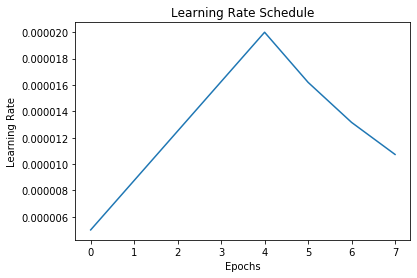

In [13]:
def build_lrfn(lr_start          = 0.000005,
               lr_max            = 0.000020 * strategy.num_replicas_in_sync,
               lr_min            = 0.000001, 
               lr_rampup_epochs  = 4,  
               lr_sustain_epochs = 0, 
               lr_decay          = 0.8): 
    
    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

lrfn = build_lrfn()

plt.plot([lrfn(epoch) for epoch in range(EPOCHS)])
plt.title('Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.show()

### 5.03 Compiler Metrics

In [14]:
# Define metrics to observe while training
METRICS = [keras.metrics.AUC(name='auc')]

### 5.04 Metdata Model

In [15]:
# The model we'll feed the metadata into before concatenation
model_metadata = keras.Sequential()

if read_images_in_fold == True:
    model_metadata.add(keras.layers.Dense(256, activation='relu', input_shape=(X_train_df.shape[1] - 1,)))
elif read_images_in_fold == False:
    model_metadata.add(keras.layers.Dense(256, activation='relu', input_shape=(X_train_df.shape[1],)))
    
model_metadata.add(keras.layers.BatchNormalization())
model_metadata.add(keras.layers.Dropout(0.2))

model_metadata.add(keras.layers.Dense(256, activation='relu'))
model_metadata.add(keras.layers.BatchNormalization())
model_metadata.add(keras.layers.Dropout(0.4))

### 5.05 CNN Models

In [16]:
# The model we'll feed the images into before concatenation
def get_cnn_model(kfold, model_to_use=MODEL_TO_USE, verbose=1):
    """
    Returns the model object and the name of the final layer in the model.
    
    *kfold: (int) fold that the CV is currently on (to determine img size)
    *model_to_use: (string) model to retrieve
    *verbose: ([0,1]) level of output communication. 0=None, 1=All.
    """
    if verbose == 1:
        print('\nLoading pretrained model...')
    
    densenet121_weights        = 'pretrained/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'
    densenet169_weights        = 'pretrained/densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5'
    densenet201_weights        = 'pretrained/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5'
    efficientnet_b0_weights    = 'pretrained/efficientnet-b0_imagenet_1000_notop.h5'
    efficientnet_b1_weights    = 'pretrained/efficientnet-b1_imagenet_1000_notop.h5'
    efficientnet_b2_weights    = 'pretrained/efficientnet-b2_imagenet_1000_notop.h5'
    efficientnet_b3_weights    = 'pretrained/efficientnet-b3_imagenet_1000_notop.h5'
    efficientnet_b4_weights    = 'pretrained/efficientnet-b4_imagenet_1000_notop.h5'
    efficientnet_b5_weights    = 'pretrained/efficientnet-b5_imagenet_1000_notop.h5'
    inception_resnetv2_weights = 'pretrained/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
    inceptionv3_weights        = 'pretrained/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
    resnet50v2_weights         = 'pretrained/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
    resnet101v2_weights        = 'pretrained/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
    resnet152v2_weights        = 'pretrained/resnet152v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
    resnext50_weights          = 'pretrained/resnext50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    resnext101_weights         = 'pretrained/resnext101_weights_tf_dim_ordering_tf_kernels_notop.h5'
    vgg19_weights              = 'pretrained/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
    xception_weights           = 'pretrained/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
                    
    input_shape = (
        kfold_params[kfold]['ROWS'],
        kfold_params[kfold]['COLS'],
        CHANNELS
    )
    
    # DenseNet121
    if model_to_use == 'densenet121':
        from tensorflow.keras.applications import DenseNet121
        model_return = DenseNet121(include_top=False, weights=densenet121_weights,
                                  input_shape=input_shape)
        
    # DenseNet169
    elif model_to_use == 'densenet169':
        from tensorflow.keras.applications import DenseNet169
        model_return = DenseNet169(include_top=False, weights=densenet169_weights,
                                  input_shape=input_shape)
        
    # DenseNet201
    elif model_to_use == 'densenet201':
        from tensorflow.keras.applications import DenseNet201
        model_return = DenseNet201(include_top=False, weights=densenet201_weights,
                                  input_shape=input_shape)
            
    # EfficientNet_B0
    elif model_to_use == 'efficientnet_b0':
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB0(include_top=False, weights=efficientnet_b0_weights,
                                         input_shape=input_shape)
            
    # EfficientNet_B1
    elif model_to_use == 'efficientnet_b1':
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB1(include_top=False, weights=efficientnet_b1_weights,
                                         input_shape=input_shape)
            
    # EfficientNet_B2
    elif model_to_use == 'efficientnet_b2':
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB2(include_top=False, weights=efficientnet_b2_weights,
                                         input_shape=input_shape)
            
    # EfficientNet_B3
    elif model_to_use == 'efficientnet_b3':
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB3(include_top=False, weights=efficientnet_b3_weights,
                                         input_shape=input_shape)
            
    # EfficientNet_B4
    elif model_to_use == 'efficientnet_b4':
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB4(include_top=False, weights=efficientnet_b4_weights,
                                         input_shape=input_shape)
            
    # EfficientNet_B5
    elif model_to_use == 'efficientnet_b5':
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB5(include_top=False, weights=efficientnet_b5_weights,
                                         input_shape=input_shape)

    # InceptionResNetV2
    elif model_to_use == 'inception_resnetv2':
        from tensorflow.keras.applications import InceptionResNetV2
        model_return = InceptionResNetV2(include_top=False, weights=inception_resnetv2_weights,
                                               input_shape=input_shape)

    # InceptionV3
    elif model_to_use == 'inceptionv3':
        from tensorflow.keras.applications import InceptionV3
        model_return = InceptionV3(include_top=False, weights=inceptionv3_weights,
                                  input_shape=input_shape)
    
    # ResNet50V2
    elif model_to_use == 'resnet50v2':
        from tensorflow.keras.applications import ResNet50V2
        model_return = ResNet50V2(include_top=False, weights=resnet50v2_weights,
                                input_shape=input_shape)

    # ResNet101V2
    elif model_to_use == 'resnet101v2':
        from tensorflow.keras.applications import ResNet101V2
        model_return = ResNet101V2(include_top=False, weights=resnet101v2_weights,
                                  input_shape=input_shape)

    # ResNet152V2
    elif model_to_use == 'resnet152v2':
        from tensorflow.keras.applications import ResNet152V2
        model_return = ResNet152V2(include_top=False, weights=resnet152v2_weights,
                                  input_shape=input_shape)

    # ResNeXt50
    elif model_to_use == 'resnext50':
        from keras_applications.resnext import ResNeXt50
        model_return = ResNeXt50(include_top=False, weights=resnext50_weights,
                              input_shape=input_shape,
                              backend=keras.backend, 
                              layers=keras.layers, 
                              models=keras.models, 
                              utils=keras.utils)

    # ResNeXt101
    elif model_to_use == 'resnext101':
        from keras_applications.resnext import ResNeXt101
        model_return = ResNeXt101(include_top=False, weights=resnext101_weights,
                                input_shape=input_shape,
                                backend=keras.backend, 
                                layers=keras.layers, 
                                models=keras.models, 
                                utils=keras.utils)
        
    # VGG19
    elif model_to_use == 'vgg19':
        from tensorflow.keras.applications import VGG19
        model_return = VGG19(include_top=False, weights=vgg19_weights,
                      input_shape=input_shape)

    # Xception
    elif model_to_use == 'xception':
        from tensorflow.keras.applications import Xception
        model_return = Xception(include_top=False, weights=xception_weights,
                                  input_shape=input_shape)
        
    return(model_return)

### 5.06 Concatenating Models

In [17]:
def get_complete_model(model_cnn, model_metadata, verbose=1):
    """
    Concatenate multiple models, add hidden layers after concatenation
    and return complete concatenated model
    
    *model_cnn: the loaded cnn model object to input 
    *model_metadata: the loaded metadata model object to input
    *verbose: ([0,1]) level of output communication. 0=None, 1=All.
    """
    
    if verbose == 1:
        print('Creating complete model...\n')
    # Pretrained cnn model with GlobalAveragePooling
    model_cnn_base = keras.Sequential([
        Model(model_cnn.input, model_cnn.output),
        keras.layers.GlobalAveragePooling2D()
    ])
    
    # Concatenate CNN model with metadata model
    model_concat = concatenate([model_cnn_base.output, model_metadata.output], axis=1)
    
    # Output layer
    model_concat = keras.layers.Dense(1, activation='sigmoid', name='final_output')(model_concat)
    model_complete = Model(inputs=[model_cnn_base.input, model_metadata.input], outputs=model_concat)
    return model_complete

### 5.07 Stratified Group Cross Validation

In [18]:
def stratified_group_k_fold(X, y, groups, k, seed=SEED):
    """ https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation """
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, 
                                   key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

### 5.08 Train Model

In [19]:
def get_in_fold_data(kfold, tdx, vdx, read_images_in_fold=read_images_in_fold, loading_bar=False):
    """
    
    *kfold: (int) the current fold in CV
    *tdx: (list of ints) train indices for the current fold
    *vdx: (list of ints) validation indices for the current fold
    *read_images_in_fold: (bool) whether to read the images inside or outside of folds
    *loading_bar: (bool) include a loading bar when loading CV images
    """
    
    print('Fetching data...')
    
    # Get values for metadata
    X_met, X_met_val, = X_train_df[tdx], X_train_df[vdx]
    # Get values for target
    y, y_val = y_train[tdx], y_train[vdx]        
    
    if read_images_in_fold == False:
        # Extract images from full image array
        X_met, X_met_val = X_met[:, 1:], X_met_val[:, 1:] # Remove name col
        X_met, X_met_val = X_met.astype(np.uint8), X_met_val.astype(np.uint8) # Change np type - must be uint8
        
        # Get values for imgs
        X_img = cv2.resize(X_train_img[tdx],
                                      (kfold_params[kfold]['ROWS'],  # Row size for current fold
                                       kfold_params[kfold]['COLS'])) # Col size for current fold
        X_img_val = cv2.resize(X_train_img[vdx], 
                               (kfold_params[kfold]['ROWS'],  # Row size for current fold
                                kfold_params[kfold]['COLS'])) # Col size for current fold
            
    elif read_images_in_fold == True:
        # Read images in from scratch
        X_img = np.array(read_jpgs(X_met[:,0], # Img names
                                   rows=kfold_params[kfold]['ROWS'], # Row size for current fold
                                   cols=kfold_params[kfold]['COLS'], # Col size for current fold
                                   loading_bar=loading_bar))
        
        X_img_val = np.array(read_jpgs(X_met_val[:,0], # Img names
                                       rows=kfold_params[kfold]['ROWS'], # Row size for current fold
                                       cols=kfold_params[kfold]['COLS'], # Col size for current fold
                                       loading_bar=loading_bar))
        
        X_met, X_met_val = X_met[:, 1:], X_met_val[:, 1:] # Remove name col
        X_met, X_met_val = X_met.astype(np.uint8), X_met_val.astype(np.uint8)

        
    return X_img, X_img_val, X_met, X_met_val, y, y_val

In [20]:
def make_test_augmentations(img):
    """
    Returns augmented image(s) and original.
    """
    img_augs = np.concatenate((#np.expand_dims(img, axis=0),
                               np.expand_dims(np.rot90(img, 1), axis=0),
                               np.expand_dims(np.rot90(img, 2), axis=0),
                               np.expand_dims(np.rot90(img, 3), axis=0),
                               np.expand_dims(np.fliplr(img), axis=0),
                               np.expand_dims(np.fliplr(np.rot90(img, 1)), axis=0),
                               np.expand_dims(np.fliplr(np.rot90(img, 2)), axis=0),
                               np.expand_dims(np.fliplr(np.rot90(img, 3)), axis=0)),
                              axis=0)
        
    return(img_augs)

In [ ]:
def train_model(model_to_use=MODEL_TO_USE):

    k.clear_session()

    skf = stratified_group_k_fold(X=X_train_df, y=y_train, groups=groups, k=KFOLDS, seed=SEED)
    rocauc_scores = []

    print(f'TRAINING {model_to_use.upper()} ON ' + str(KFOLDS) + ' FOLDS\n')
    for fold, (tdx, vdx) in enumerate(skf):
        print(f'Fold : {fold}')
        print('Img size: ' + str(kfold_params[fold]['ROWS']) + 'x' + str(kfold_params[fold]['ROWS']))
        print('Augmentation: ' + str(kfold_params[fold]['AUG']))
        print(f'Training on {len(tdx)} samples.')
        print(f'Validating on {len(vdx)} samples.')

        # Load pretrained model & create name to save weights by
        model_cnn = get_cnn_model(kfold=fold, model_to_use=MODEL_TO_USE)
        model_save_name = 'weights/' + model_name_save + '/' + model_name_save + '_' + str(fold) + '.h5'

        # Fetch in-fold data
        X_img, X_img_val, X_met, X_met_val, y, y_val = get_in_fold_data(kfold=fold, tdx=tdx, vdx=vdx)

        # Image Preprocessing
        #X_img, X_img_val = preprocess_imgs(train_imgs=X_img, test_imgs=X_img_val)

        # Image augmentations
        X_img, X_met, y = make_train_augmentations(X_img=X_img, 
                                                   X_met=X_met, 
                                                   y=y, 
                                                   p=0.4, 
                                                   aug=kfold_params[fold]['AUG'])


        # CONCATENATED MODEL - Edit below
        model = get_complete_model(model_cnn=model_cnn, 
                                   model_metadata=model_metadata)

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
        # Define learning rate schedule
        lr = LearningRateScheduler(lrfn, verbose=True)
        # Define early stopping parameters
        es = EarlyStopping(monitor='val_auc', 
                           mode='max',
                           restore_best_weights=True, 
                           verbose=1, 
                           patience=3)
        # Define model checkpoint parameters
        mc = ModelCheckpoint(filepath=model_save_name, 
                             save_best_only=True, 
                             save_weights_only=True,
                             monitor='val_auc', 
                             mode='max', 
                             verbose=0)

        # Fit model
        model.fit([X_img, X_met], y,
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  callbacks = [es, lr, mc],
                  class_weight=class_weight,
                  verbose=1,
                  validation_split=0.25)  
        
        del [X_img, X_met, y]

        # TTAs and validation predictions
        print('\nMaking val predictions')
        preds = []
        for val_idx in range(len(X_img_val)):
            # Add augmented images to each img in X_img_val
            X_img_val_augs = np.concatenate((np.expand_dims(X_img_val[val_idx], axis=0),
                                        make_test_augmentations(X_img_val[val_idx])))
            # Add copies of each corresponding X_met_val for the augmented imgs
            X_met_val_augs = np.array([X_met_val[val_idx]] * len(X_img_val_augs))
            
            # Make prediction for each record
            pred = model.predict([X_img_val_augs, X_met_val_augs])
            pred = np.mean(pred, axis=0)
            preds.append(pred)
            
        # Calculate OOF ROCAUC following TTAs
        oof_rocauc = metrics.roc_auc_score(y_val, preds)

        print('')
        print('\nFold ' + str(fold) + ' ROCAUC: ' + str(oof_rocauc))
        print('')
        rocauc_scores.append(oof_rocauc)
        
        # Clean up
        del [X_img_val, X_met_val, y_val, pred, tdx, vdx, model, oof_rocauc]
        gc.collect()

    print('\n\n############################')
    print('Mean OOF ROCAUC: '+ str(np.mean(rocauc_scores))+' (±'+str(round(np.std(rocauc_scores), 5))+')')    
    print('############################\n\n')
    return(rocauc_scores)

rocauc_scores = train_model(model_to_use=MODEL_TO_USE)

# Save the fold results
rocauc_scores = pd.DataFrame({'rocauc':rocauc_scores})
rocauc_scores_name = f'scores/{model_name_save}_scores.csv'
rocauc_scores.to_csv(rocauc_scores_name, index=False)

In [ ]:
print(f'--------------\nFOLD SCORES\n--------------\n{rocauc_scores}')
print(f'\n--------------\nFOLD STATS\n--------------\n{rocauc_scores.describe()}')

plt.plot(rocauc_scores.index, rocauc_scores, marker='.')
plt.title('ROCAUC Fold Results')
plt.xlabel('Fold')
plt.ylabel('ROCAUC')
plt.show()

## 6.00 Testing 
### 6.01 Test metadata

In [21]:
# Clean up memory
try:
    del [X_train_img, X_train_df, y_train]
except:
    pass

test_df = pd.read_csv(test_metadata_path)
duplicates = pd.read_csv('2020_Challenge_duplicates.csv')

# Replace whitespace in anatom_site_general_challenge with underscore
test_df['anatom_site_general_challenge'] = test_df['anatom_site_general_challenge'].replace(' ', '_', regex=True)

# Encode sex feature
test_df = test_df.merge(pd.get_dummies(test_df[['sex','anatom_site_general_challenge']]), 
                        left_index=True, right_index=True)
test_df.drop(['patient_id','sex', 'anatom_site_general_challenge'], axis=1, inplace=True)

# Remove duplicates
test_df[(~test_df['image_name'].isin(duplicates['ISIC_id_paired']))]

test_df = np.asarray(test_df)

del duplicates
test_df

array([['ISIC_0052060', 70.0, 0, ..., 0, 0, 0],
       ['ISIC_0052349', 40.0, 0, ..., 0, 0, 0],
       ['ISIC_0058510', 55.0, 1, ..., 0, 1, 0],
       ...,
       ['ISIC_9997917', 25.0, 0, ..., 0, 0, 1],
       ['ISIC_9998234', 65.0, 0, ..., 0, 0, 0],
       ['ISIC_9999302', 30.0, 0, ..., 0, 0, 1]], dtype=object)

### 6.02 Test CNN Model

In [22]:
def import_model(kfolds, model_to_use=MODEL_TO_USE):
    """
    *kfolds: list object of applicable folds. (Not an int)
    """
    models = []
    for fold in tqdm(range(kfolds)):
        model_cnn = get_cnn_model(kfold=fold, model_to_use=MODEL_TO_USE, verbose=0)
        
        model = get_complete_model(model_cnn=model_cnn, 
                                   model_metadata=model_metadata,
                                   verbose=0)

        model.load_weights('../output/weights/' + model_name_save + '/' + model_name_save + '_' + str(fold) + '.h5')
        models.append(model)
    return(models)

### 6.03 Test Augmention Pipeline

In [23]:
def make_test_augmentations(img):
    """
    Returns augmented image(s) and original.
    """
    img_augs = np.concatenate((np.expand_dims(img, axis=0),
                               np.expand_dims(np.rot90(img, 1), axis=0),
                               np.expand_dims(np.rot90(img, 2), axis=0),
                               np.expand_dims(np.rot90(img, 3), axis=0),
                               np.expand_dims(np.fliplr(img), axis=0),
                               np.expand_dims(np.fliplr(np.rot90(img, 1)), axis=0),
                               np.expand_dims(np.fliplr(np.rot90(img, 2)), axis=0),
                               np.expand_dims(np.fliplr(np.rot90(img, 3)), axis=0)),
                              axis=0)
        
    return(img_augs)

### 6.04 Make Submission

In [24]:
def make_submission(test_df):
    
    # Read images in and predict
    preds_test = [] # We'll store the final prediction for each image here
    
    # Convert pixel values to float
    #print('Preparing image standardiser...')
    #train_imgs = train_imgs.astype(float)
    # Get per-channel means and stds
    #train_means = train_imgs.reshape(-1, train_imgs.shape[-1]).mean(axis=0)
    #train_stds = train_imgs.reshape(-1, train_imgs.shape[-1]).std(axis=0)
    
    print('Getting models...')
    time.sleep(2)
    # Retrieve model to use - as per fold image sizes
    models = import_model(kfolds=KFOLDS, model_to_use=MODEL_TO_USE)
    
    print('Generating predictions...')
    time.sleep(2)
    # Loop through all the test images
    for image_row in tqdm(test_df):
        # Get image data from dicom file
        image_path = os.path.join(test_img_path, image_row[0]) + '.jpg'
        # Read the dcm image in
        image = cv2.imread(image_path)     

        # Drop image name from metadata
        image_row = np.delete(image_row, 0).astype(np.uint8)
        image_row = np.expand_dims(image_row, axis=0)
        
        # AUGMENTATIONS
        images_all = make_test_augmentations(image)
        
        pred_proba_list = []        
        for image in images_all:
            image = np.expand_dims(image, axis=0)

            pred_proba = np.mean([model.predict([image, image_row]) for model in models], axis=0)
            pred_proba_list.append(pred_proba)
        
        pred_proba = np.mean(pred_proba_list, axis=0)
        preds_test.append(pred_proba.tolist()[0][0])
        
    # Create submission df
    submission = pd.DataFrame({sample_sub.columns[0]:test_df[:,1],
                           sample_sub.columns[1]:preds_test})
   
    return(submission)

In [ ]:
# Create submission
submission = make_submission(test_df=test_df)

Getting models...


100%|██████████| 8/8 [01:17<00:00, 10.29s/it]


Generating predictions...


  1%|          | 136/10982 [10:53<13:59:19,  4.64s/it]WARNING: Logging before flag parsing goes to stderr.
E0817 17:34:14.958288 139882653075264 ultratb.py:155] Internal Python error in the inspect module.
Below is the traceback from this internal error.



In [ ]:
submission_name = f'submissions/{model_name_save}_submission.csv'
submission.to_csv(submission_name, index=False)

In [ ]:
submission.head()

In [ ]:
del submission

In [ ]:
# Some definitions going forward
ROWS = 512 # Default row size
COLS = 512 # Default col size
CHANNELS = 3

EPOCHS = 8
BATCH_SIZE = 8
CLASSES = 2

# Read all images in and subset in CV, or Read images inside each fold in CV
read_images_in_fold = True

# -- Models ran -- 
#MODEL_TO_USE = 'densenet201'
#MODEL_TO_USE = 'inception_resnetv2' 
#MODEL_TO_USE = 'xception'
#MODEL_TO_USE = 'inceptionv3'

# -- Submissions generated -- 
MODEL_TO_USE = 'vgg19'

# -- Staged for running --
#MODEL_TO_USE = 'efficientnet_b5'
####MODEL_TO_USE = 'resnext101'
#MODEL_TO_USE = 'resnet152v2'
####MODEL_TO_USE = 'efficientnet_b0'
####MODEL_TO_USE = 'efficientnet_b1'
####MODEL_TO_USE = 'efficientnet_b2'
####MODEL_TO_USE = 'efficientnet_b3'
####MODEL_TO_USE = 'efficientnet_b4'
####MODEL_TO_USE = 'densenet169'
####MODEL_TO_USE = 'densenet121'
####MODEL_TO_USE = 'resnet50v2'
####MODEL_TO_USE = 'resnet101v2'
####MODEL_TO_USE = 'resnext50'


# Parameters for each fold
# standard_models = [128, 256, 384, 512]
# efficient_nets = [224, 240, 260, 300, 380, 456]

kfold_params = {
    0: {'ROWS':ROWS,'COLS':COLS,'AUG':'fliplr'},
    1: {'ROWS':ROWS,'COLS':COLS,'AUG':'rot90' },
    2: {'ROWS':ROWS,'COLS':COLS,'AUG':'rot180'},
    3: {'ROWS':ROWS,'COLS':COLS,'AUG':'rot270'},
    4: {'ROWS':ROWS,'COLS':COLS,'AUG':'fliplr'},
    5: {'ROWS':ROWS,'COLS':COLS,'AUG':'rot90' },
    6: {'ROWS':ROWS,'COLS':COLS,'AUG':'rot180'},
    7: {'ROWS':ROWS,'COLS':COLS,'AUG':'rot270'}

}

KFOLDS = len(kfold_params)

SEED = 14
np.random.seed(SEED)

model_name_save = MODEL_TO_USE + '_' + str(ROWS) + 'x' + str(COLS) + '_seed' + str(SEED)

# Create weights path if does not exist already
if not os.path.exists(f'weights/{model_name_save}'):
    os.mkdir(f'weights/{model_name_save}')

print(f'Model name: {model_name_save}')

In [ ]:
# Create submission
submission = make_submission(test_df=test_df)

In [ ]:
submission_name = f'submissions/{model_name_save}_submission.csv'
submission.to_csv(submission_name, index=False)

In [ ]:
submission.head()